# Get percentage of fixations for us and for them AUPRC
# Start at a fixed point
# Shorten sequence length

1. Results table 
2. Fine-tuning their model on fixations
3. Regression 
4. Identify if it is the same text or participant
4. Look at gaze papers 

## Imports

In [2]:
# Import obf functionality
import sys
from pathlib import Path
sys.path.append(str(Path("../../OBF").resolve()))

from obf.model import ae
from obf.model import creator


In [42]:
from eyemind.dataloading.load_dataset import limit_sequence_len, get_label_mapper, get_filenames_for_dataset, create_filename_col, get_stratified_group_splits
from eyemind.dataloading.gaze_data import GazeDataModule
from eyemind.models.classifier import EncoderClassifierModel
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import SubsetRandomSampler, DataLoader
from pytorch_lightning import Trainer


## DataLoading

In [4]:
data_folder = Path("/Users/rickgentry/emotive_lab/eyemind/data/processed/fixation")

In [9]:
def fixation_label_mapper(files):
    labels = []
    for f in files:
        df = pd.read_csv(f)
        label_array = df['fixation_label'].to_numpy(float)
        labels.append(label_array)
    return labels


In [10]:
def limit_label_seq(y_data, sequence_length, pad_token=-1.):
    if len(y_data) > sequence_length:
        y_data = y_data[:sequence_length]
    else:
        pad_data = np.ones((sequence_length,)) * pad_token
        pad_data[:len(y_data)] = y_data
        y_data = pad_data
    return y_data



In [11]:
from functools import partial
sequence_len = 500
lim_seq_len = partial(limit_sequence_len, sequence_len=sequence_len, random_part=False)
limit_labels = partial(limit_label_seq, sequence_length=sequence_len)

In [12]:
transforms = [lim_seq_len,lambda data: torch.tensor(data).float()]
dm = GazeDataModule(data_folder, label_mapper=fixation_label_mapper, transform_x=transforms, transform_y=[limit_labels,lambda data: torch.tensor(data).float()])

In [13]:
dm.setup(stage="test")

6279 6279


In [14]:
test_dl = dm.test_dataloader(shuffle=True)

## Data Exploration

### Fixation Counts

In [17]:
# Get fixation counts
def count_fixation_percentage_folder():
    fixation_count = 0
    total_labels = 0

    for filepath in Path.glob(data_folder, "*.csv"):
        df = pd.read_csv(filepath)
        total_labels += len(df['fixation_label'])
        fixation_count += df['fixation_label'].sum()
    return fixation_count / total_labels, fixation_count, total_labels

In [26]:
def get_inv_ratios(fixation_count, total_labels):
    inv_ratio_fix = 1 / (fixation_count / (total_labels - fixation_count))
    inv_ratio_sacc = 1 / ((total_labels - fixation_count)/ fixation_count)
    return inv_ratio_sacc, inv_ratio_fix

In [29]:
def fixation_label_counts(dl):
    total_labels = 0
    fixation_count = 0
    for _, labels in dl:
        fixation_count += labels.sum().numpy()
        total_labels += torch.numel(labels)
    return fixation_count, total_labels

In [34]:
def get_class_weights(dl):
    fixation_count, total_labels = fixation_label_counts(dl)
    inv_ratio_sacc, inv_ratio_fix = get_inv_ratios(fixation_count, total_labels)
    inv_ratios = np.array([inv_ratio_sacc, inv_ratio_fix])
    print(inv_ratios)
    class_weights = inv_ratios / inv_ratios.sum()
    return class_weights


### Fixation Data Visualization

In [55]:
import matplotlib
def plot_fix_signal(signal, labels):
    sl = signal.shape[0]
    x = signal[:,0]
    y = signal[:,1]
    labels = labels.astype(int)
    label_colors ={0: 'green', 1: 'red'}
    for l in np.unique(labels):
        ix = np.where(labels == l)
        plt.plot(list(range(sl)), x[ix], c = label_colors[l], label=l)
        plt.plot(list(range(sl)), y[ix], c = label_colors[l], label=l)
    plt.legend()
    plt.show()

In [60]:
from eyemind.obf.utils.signal_visualization import xy_t_fix_signal

def visualize_random_example(dl, plot_fn, scale_fix=1):
    for signals, labels in dl:
        signal = signals[0].numpy()
        label = labels[0].numpy() * scale_fix
        plot_fn(signal, label)
        break
    



In [75]:
from eyemind.preprocessing.signal_normalizing import get_pixels_per_degree, get_screen_limits

# Stats of setup
screen_res = (1920,1080)
screen_size = (525.78,297.18)
subject_dist = 989
screen_center = (screen_res[0]//2,screen_res[1]//2)

pixels_per_deg = get_pixels_per_degree(screen_res, screen_size, subject_dist)
x_lims, y_lims = get_screen_limits(screen_res, pixels_per_deg)
print(x_lims)
print(y_lims)

29.771588490882394
17.088726202979693


In [130]:
def vizualize_fix_signal(inputs, fixations, lims=(-10,10), title="Fixation ID Signal"):

    n1 = inputs.shape[0]
    max_val = inputs.max()

    # The input sequence
    plt.plot(list(range(n1)),
            inputs[:, 0],
            label="x",
            color="orange",
            alpha=0.8)
    plt.plot(list(range(n1)),
            inputs[:, 1],
            label="y",
            color="blue",
            alpha=0.8)

    # The Ground truth sequence
    saccade_gt_time = np.where(fixations == 0)[0]
    plt.scatter(saccade_gt_time,
                saccade_gt_time * 0,
                label="GT Sac",
                color="green",
                alpha=0.2)
    fix_gt_time = np.where(fixations == 1)[0]
    plt.scatter(fix_gt_time,
                np.ones((len(fix_gt_time),)) * max_val,
                label="GT Fix",
                color="red",
                alpha=0.2)
    plt.ylim(*lims)
    plt.title(title)
    plt.legend()
    plt.show()
                

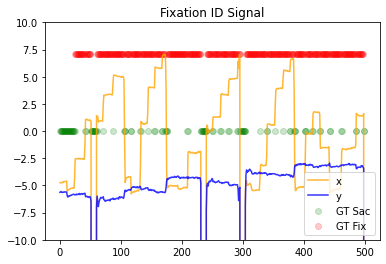

In [134]:
visualize_random_example(test_dl, vizualize_fix_signal)

In [113]:
def show_signal_on_screen_with_fixations(
                signal, 
                labels,
                screen_width=29.77,
                screen_height=17.09,
                resolution_magnifier=10,
                scatter_size = 5,
                off_screen_factor = 2,
                title=""):
  """
  
  
  Args:
    signal: 2D signal
    labels: 0 or 1 for saccade or fixation
    screen_width: unit is visual degrees
    screen_height: unit is visual degrees
    resolution_magnifier (int): magnify visualization 
    
  """

  # background image: * 2 for off-screen gazes
  img = np.zeros((int(screen_height * off_screen_factor * resolution_magnifier), int(screen_width * off_screen_factor * resolution_magnifier), 3),
                 dtype=np.float32)

  for i,(x, y) in enumerate(signal):
    xi = int(x * resolution_magnifier + screen_width * resolution_magnifier)
    yi = int(y * resolution_magnifier + screen_height * resolution_magnifier)

    try:
      label = labels[i]
      if label == 0:
        img[yi - scatter_size:yi + scatter_size+1, xi - scatter_size:xi + scatter_size+1, 1] += 0.9
      elif label == 1:
        img[yi - scatter_size:yi + scatter_size+1, xi - scatter_size:xi + scatter_size+1, 0] += 0.9
      else:
        raise Exception("Label was not 0 or 1")
    except Exception as e:
      print(e)

  img = np.clip(img, 0, 1)
  plt.imshow(img)

  plt.title(title)
  plt.show()

In [114]:
def get_random_example_from_dataloader(dl):
    x_batch, y_batch = next(iter(dl))
    x, y = x_batch[0], y_batch[0]
    return x, y

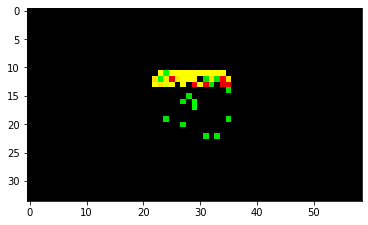

In [161]:
signal, labels = get_random_example_from_dataloader(test_dl)
show_signal_on_screen_with_fixations(signal, labels,resolution_magnifier=1,scatter_size=0, off_screen_factor=2)

## Model

In [34]:
pre_trained_weights_dir = Path("../OBF/pre_weights/sample_weights")

In [35]:
encoder = creator.load_encoder(str(pre_trained_weights_dir.resolve()))

Loading:  /Users/rickgentry/emotive_lab/eyemind/OBF/pre_weights/sample_weights/encoder_1633040995_gru.pt


In [11]:
print(encoder)

Sequential(
  (0): CNNEncoder(
    (cnn): Sequential(
      (0): ConvBlock(
        (conv): Conv1d(2, 14, kernel_size=(7,), stride=(1,), padding=(3,))
        (pool_layer): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
        (bn): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (1): ConvBlock(
        (conv): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=(3,))
        (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.01)
      )
    )
  )
  (1): RNNEncoder(
    (rnn): GRU(32, 128, num_layers=2, batch_first=True, dropout=0.1)
  )
)


In [12]:
fi_decoder = torch.load(str(Path(pre_trained_weights_dir, "fi_1633040995_gru.pt").resolve()),map_location=torch.device('cpu'))


In [13]:
from torchsummary import summary
print(fi_decoder)


RNNDecoder(
  (rnn): GRU(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out_fc): Linear(in_features=128, out_features=2, bias=True)
)


In [14]:
class FixationIdentifier(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        embeddings = self.encoder(x)
        output = self.decoder(embeddings)
        return output
        

In [15]:
fid_model = FixationIdentifier(encoder, fi_decoder)

In [16]:
print(fid_model)

FixationIdentifier(
  (encoder): Sequential(
    (0): CNNEncoder(
      (cnn): Sequential(
        (0): ConvBlock(
          (conv): Conv1d(2, 14, kernel_size=(7,), stride=(1,), padding=(3,))
          (pool_layer): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
          (bn): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): ConvBlock(
          (conv): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=(3,))
          (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.01)
        )
      )
    )
    (1): RNNEncoder(
      (rnn): GRU(32, 128, num_layers=2, batch_first=True, dropout=0.1)
    )
  )
  (decoder): RNNDecoder(
    (rnn): GRU(128, 128, num_layers=2, batch_first=True, dropout=0.1)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [38]:
batch = next(iter(test_dl))

In [39]:
x,y = batch

In [58]:
logits = fid_model(x)

In [60]:
logits.softmax(dim=2).shape

torch.Size([8, 500, 2])

In [45]:
preds = logits.argmax(dim=2).detach().cpu().numpy().reshape(-1)

In [61]:
probs = logits.softmax(dim=2)[:,:,1].detach().cpu().numpy().reshape(-1)

In [64]:
y = y.cpu().numpy().reshape(-1)

In [66]:
auc = metrics.roc_auc_score(y, probs)

In [67]:
auc

0.6506709492371336

In [68]:
acc = metrics.accuracy_score(y, preds)


In [69]:
acc

0.73525

In [93]:
import sklearn.metrics as metrics
import tqdm

def evaluate(dl, model):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    for x, y in tqdm.tqdm(dl):
        logits = model(x)
        preds = logits.argmax(dim=2).detach().cpu().numpy().reshape(-1)
        probs = logits.softmax(dim=2)[:,:,1].detach().cpu().numpy().reshape(-1)
        y = y.cpu().numpy().reshape(-1)
        all_preds += preds.tolist()
        all_labels += y.tolist()
        all_probs += probs.tolist()
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    masked_indices = all_labels == -1
    acc = metrics.accuracy_score(all_labels[~masked_indices], all_preds[~masked_indices])
    auc = metrics.roc_auc_score(all_labels[~masked_indices], all_probs[~masked_indices])
    return acc, auc





In [72]:
preds, labels, probs = evaluate(test_dl, fid_model)

100%|██████████| 784/784 [08:00<00:00,  1.63it/s]


In [91]:
preds = np.array(preds)
acc = metrics.accuracy_score(labels[~indices_masked], preds[~indices_masked])


In [92]:
acc

0.7467187887901037

In [81]:
labels = np.array(labels)

In [86]:
probs = np.array(probs)

In [88]:
auc = metrics.roc_auc_score(labels[~indices_masked], probs[~indices_masked])

In [89]:
auc

0.6525304778413941